C:\Users\Zaman\AppData\Local\Julia-0.3.10

In [4]:
# Mohammad Asif Zaman
# Original version date: Aug. 2015
# Current version date: June 4, 2018
# Main Julia notebook (Jupyter) file
# ========================================

# The following files are requried to run this code:
# 1. fitness.jl
# 2. progress_bar.jl

In [5]:
# The following packages must be installed

using PyCall
using PyPlot


In [6]:
include("progress_bar.jl");
include("fitness.jl");


In [24]:
# Setting up the parameters for the optimization algorithm

bL = 5*[-1, -1, -1];      # lower limit of the parameters for the optimization
bU = 5*[1, 1, 1];         # Upper limit of the parameters for the optimization

D = length(bL);           # Dimension = 3 for the test fitness function.
gmax = 100;               # Maximum number of generations (max iteration number)
Ns = 20;                  # tests for step variation
NT = 15;                  # tests for temperature reduction
rT = 0.85;                # reduction coefficient
ci = 2;                   # varying criterion



In [28]:
# Calculating the starting temperature, T0
# There are multiple methods for selecting the starting temperature. It is usually kept at the same
# order of magnitude as the standard deviation of the cost/fitness function.
# Here, we select the maximum deviation of the fitness function over the solution space as the initial temperature.

Nrand = 200;  # number of random points on the solution space.

# Generating some random samples within the optimization space and calculating the fitness value.
ft = zeros(Nrand,1);
for m = 1:Nrand
    xt = bL + rand(D,1).*(bU - bL);
    ft[m] = fitness(xt);
end



# T = maximum(ft)-minimum(ft);
T = 10*sqrt(var(ft));

println("Initial temperature, T0 = ", T)


Initial temperature, T0 = 0.6281791624995678


In [33]:
# Setting up variables for the optimization algorithm

x = rand(D,1);                      # random starting point. It can also be set as zero or random
x = bL + rand(D,1).*(bU - bL);      # starting point mapped into solution space
v0 = (bU-bL)./2;                    # starting step vector
f = fitness(x);                     # initial fitness value

xmod = copy(x); 
ncounter = zeros(D,1);

xopt = zeros(D,gmax);              # the solution vector at each iteration step will be saved in this variable
fopt = zeros(gmax,1);              # the fitness value at each iteration step will be saved in this variable

xopt[:,1] = copy(x);
fopt[1] = copy(f);  

Progress = 100.0% ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
elapsed time: 0.154438806 seconds


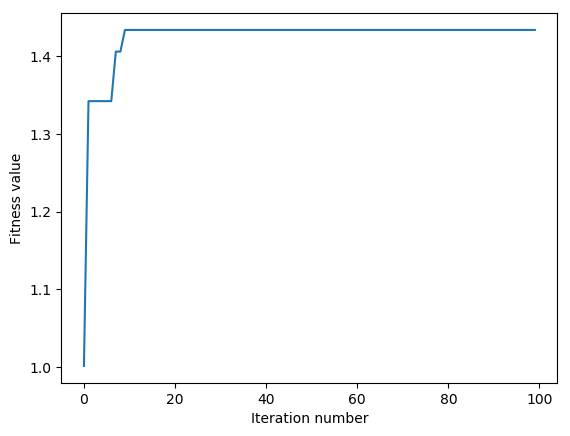

Optimized parameters = [-0.091416, -0.0819042, 0.246205]
14


In [34]:
# Simulated annealing optimization algorithm
# Ref. Angelo Corana et al. "Minimizing Multimodal Functions Of Continuous-Variables with Simulated Annealing Algorithm" (1987)

# Notes: June 3, 2018. The speed of the code seemed to be T dependent. This didn't make sense. Check the exp() function with
# T in it. Did some modification there. Added an epsilon to the numerator and denominator. Checked the braces. That solved the
# issue. Then, I removed the epsilon and the code still worked fine. Maybe there was a bracked mismatch or something. 


t1 = 1000*((60*Dates.hour(now()) + Dates.minute(now()))*60 + Dates.second(now())) + Dates.millisecond(now());
glb_cnt = 0;
epsilon =0;
tic()
for g = 1:gmax                                # Main iteration loop
    t2 = 1000*((60*Dates.hour(now()) + Dates.minute(now()))*60 + Dates.second(now())) + Dates.millisecond(now());
    
    if (t2 - t1 > 100)  || (g == gmax)                       # if ellapsed time > 100ms, then print progress bar
        progress_bar(g,gmax,20);
        t1 = copy(t2);
    end
    
    v = copy(v0);
    
    if g > 1
        xopt[:,g] = copy(xopt[:,g-1]);
        fopt[g] = copy(fopt[g-1]);
    end
    
    for nt = 1:NT                            # Looping over temperature reduction tests                   
        
        for j = 1:Ns                         # Looping over step variation tests     
            
            for m = 1:D                      # looping over each dimension
               
                xmod[m] = x[m] + 2*(rand(1)[1] -0.5)*v[m];
                while (xmod[m] > bU[m]) || (xmod[m] < bL[m])               # check if within limit
                    xmod[m] = x[m] + 2*(rand(1)[1] -0.5)*v[m];             # if not, repeat
                end
         
                fmod = fitness(xmod);
                
                
                # User Metropolis criterion to decide whether to accept xmod or not. The criterion is:
                # if fmod > f, then accept
                # else, check if a random sample is less than  exp((fmod - f)/T). if so, accept
                # otherwise, reject
                
                if (fmod > f) || (rand(1)[1] < exp(  (fmod - f) / T ) )     
                    
                    glb_cnt = glb_cnt + 1;
                    x[m] = copy(xmod[m]);
                    f = copy(fmod);
                    ncounter[m] += ncounter[m];  # count the number of accepted case
                    if fmod > fopt[g]
                        xopt[:,g] = copy(xmod);
                        fopt[g] = copy(fmod);
                    end
                end
                
                
            end
        end
        
        
        # Calculate new step vector in each direction
        for u = 1:D
            if ncounter[u]/Ns > 0.6
                v[u] = v[u]*(1+ ci/0.4*(ncounter[u]/Ns - 0.6));
            elseif ncounter[u]/Ns < 0.4
                v[u] = v[u]/(1+ ci/0.4*(0.4-ncounter[u]/Ns));
            end
            
        end

        ncounter = zeros(D,1);
    end
    
    
    T = T*rT;    # reduce temperature
    
end

println("");
toc();
sleep(0.5);

println("Optimized parameters = ", xopt[:,end])

plot(fopt)
xlabel("Iteration number");
ylabel("Fitness value");

println(glb_cnt)